In [85]:
import re
import sys
from math import floor
import time
import select

import numpy as np
import matplotlib.pyplot as plt
import pykat 
pykat.init_pykat_plotting()
%matplotlib inline

# Required custom libraries
import usbgpib
import SR785

import pyrpl
import os

In [87]:
prologix = usbgpib.find_prologix()
prologix[0].device

'/dev/cu.usbserial-PX1KPJ4C'

In [88]:
gpib = SR785.connectUSBGPIB(prologix[0].device, 10, baud=9600, debug=False)

Connecting to /dev/cu.usbserial-PX1KPJ4C:10...
Connected


In [89]:
def download_data(gpib, display):
    """
    Depending on the measurement group this function will extract the data from 
    the SR785 with the xaxis and units actually being used.
    
    Parameters
    ----------
    gpib : GPIB
        GPIB connection object
    display : int, char
        Which display output to choose from 0(A) or 1(B)
    
    Returns
    -------
    f : ndarray[float]
        Frequency vector, units Hz
    y : ndarray[float]
        Display data, units are
    unit : str
        Units of the output
    """
    if display.lower() == 'a' or display==0:
        display = 0
    elif display.lower() == 'b' or display==1:
        display = 1
    else:
        raise Exception("Invalid display input")
        
    #Get the number of points on the Display
    ret = gpib.query(f'DSPN?{display}').strip()
    if gpib.debug: print("download_display: ", ret)
        
    numPoint = int(ret.decode('UTF8'))
    
    freq=[]
    data=[]
    
    if gpib.debug: print('Expecting %i bytes' % numPoint)
    
    data = gpib.query(f"DSPB?{display}", numPoint*4).strip()
    MGRP = int(gpib.query(f'MGRP?{display}').decode().strip())
    
    if MGRP == 3: # sine group
        start = float(gpib.query('SSTR?0').decode().strip())
        end  = float(gpib.query('SSTP?0').decode().strip())
        
        if int(gpib.query(f'SSTY?{display}').decode().strip()) == 1: #log
            f = np.logspace(np.log10(start), np.log10(end), numPoint-1)
        else:
            f = np.linspace(start, end, numPoint-1)
    elif MGRP == 0: # FFT
        start = float(gpib.query(f'DBIN?{display},0').strip().decode())
        end   = float(gpib.query(f'DBIN?{display},{numPoint-1}').strip().decode())
    
        f = np.linspace(start, end, numPoint)
    else:
        raise NotImplemented()
            
    # square root character is outputted strange from SR785
    # squared is some weird special character too
    unit = gpib.query(f"UNIT?{display}").strip().replace(b'\xfd', b'^2').replace(b'\xfb', u"\u221A".encode()).decode()
    assert(len(data)//4 == numPoint)
    return f, np.frombuffer(data, count=numPoint, dtype=np.float32), unit

In [110]:
A = []
#B = []

In [115]:
for i in range(1):
    #time.sleep()
    gpib.debug = True

    fA, dataA, unitA = download_data(gpib, 'A')
    #fB, dataB, unitB = download_data(gpib, 'B')
    A.append((fA,dataA,unitA))
    #B.append((fB,dataB,unitB))

0 bytes received
5 bytes received

download_display:  b'801'
Expecting 801 bytes
0 bytes received
3204 bytes received
3205 bytes received

0 bytes received
3 bytes received

0 bytes received
17 bytes received

0 bytes received
17 bytes received

0 bytes received
5 bytes received



In [13]:
#np.savez_compressed("LZH_intensity_noise_16082019.npz", (rp14_mod_noise_floor,))

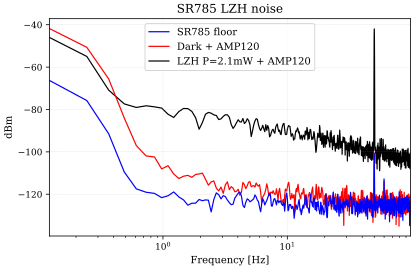

In [121]:
fig, ax = plt.subplots(1)

ax.semilogx(A[0][0][1:], A[0][1][1:])
ax.semilogx(A[1][0][1:], A[1][1][1:], zorder=-500)
ax.semilogx(A[3][0][1:], A[3][1][1:], zorder=-1000)

plt.legend(['SR785 floor', 'Dark + AMP120', 'LZH P=2.1mW + AMP120', ])
plt.title("SR785 LZH noise")

ax.set_ylabel(A[0][2])
ax.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.savefig("/Users/ddb/ownCloud3/labc/SR785_LZH_noise_2.pdf")

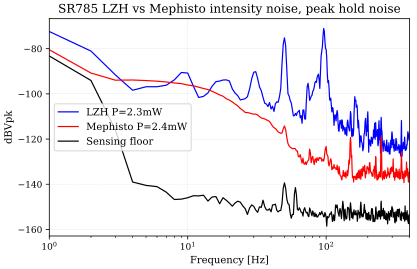

In [47]:
fig, ax = plt.subplots(1)

ax.semilogx(A[8][0][1:], A[8][1][1:])
ax.semilogx(A[10][0][1:], A[10][1][1:])
ax.semilogx(A[11][0][1:], A[11][1][1:])
    
plt.legend(['LZH P=2.3mW', 'Mephisto P=2.4mW', 'Sensing floor'])
plt.title("SR785 LZH vs Mephisto intensity noise, peak hold noise")

ax.set_ylabel(A[0][2])
ax.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.savefig("/Users/ddb/ownCloud3/labc/SR785_LZH_vs_mephisto_peak.pdf")

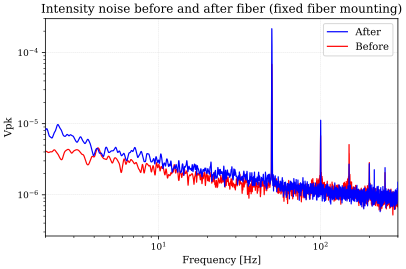

In [78]:
plt.subplots()
db = pyrpl.curvedb.CurveDB()
f1, err_spec1 = db.get(90).data
l1, = plt.loglog(f1, np.sqrt(abs(err_spec1)), zorder=10)

f2, err_spec2 = db.get(91).data
l2, = plt.loglog(f2, np.sqrt(abs(err_spec2)), zorder=-10)

plt.title("Intensity noise before and after fiber (fixed fiber mounting)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Vpk")
plt.legend([l1,l2],['After', 'Before'])
plt.xlim(2, 300)
plt.ylim(None, 3e-4)
plt.tight_layout()
plt.savefig("/Users/ddb/ownCloud3/labc/before_after_fiber_noise_fixed.pdf")

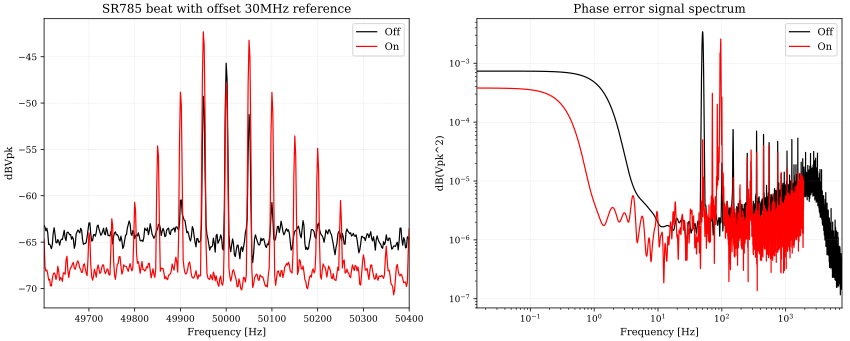

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

c = ['k','r']
for (fA,dataA,unitA),C in zip(A,c):
    axs[0].plot(fA[1:], dataA[1:], C)
    
axs[0].legend(['Off', 'On'])
axs[0].set_ylabel(unitA)
axs[0].set_xlabel("Frequency [Hz]")
axs[0].set_title("SR785 beat with offset 30MHz reference")

db = pyrpl.curvedb.CurveDB()
f1, err_spec1 = db.get(80).data
axs[1].loglog(f1, err_spec1, c[0], zorder=-10)
f2, err_spec2 = db.get(77).data
axs[1].loglog(f2, err_spec2, c[1], zorder=10)
axs[1].set_title("Phase error signal spectrum")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel("dB(Vpk^2)")
axs[1].legend(['Off', 'On'])

plt.tight_layout()

name = "/Users/ddb/ownCloud3/labc/frequency_lock_50Hz_intensity_servo_2"



#if os.path.exists(f"{name}.pdf"): raise Exception()

plt.savefig(f"{name}.pdf")

np.savez_compressed(f"{name}.npz", data=A, spectrum_off=[f1,err_spec1], spectrum_on=[f2,err_spec2])

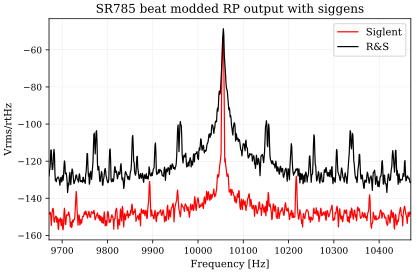

In [26]:
fig, ax = plt.subplots(1)

for (fA,dataA,unitA), (fB,dataB,unitB) in zip(A, B):
    ax.plot(fA[1:], dataA[1:], c='r')
    ax.plot(fB[1:], dataB[1:], c='k')
    
plt.legend(['Siglent', 'R&S'])

#ax.semilogx(sr785_floor[0], sr785_floor[1])

ax.set_ylabel("Vrms/rtHz")
ax.set_xlabel("Frequency [Hz]")
plt.title("SR785 beat modded RP output with siggens")
plt.tight_layout()
plt.savefig("/Users/ddb/ownCloud3/labc/SR785_beat_comp_switch_outs.pdf")

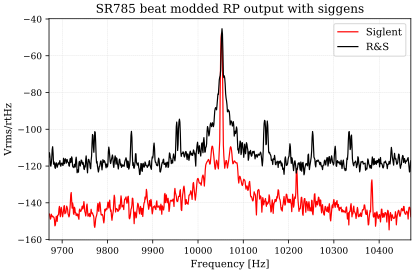

In [21]:
fig, ax = plt.subplots(1)

for (fA,dataA,unitA), (fB,dataB,unitB) in zip(A, B):
    ax.plot(fA[1:], dataA[1:], c='r')
    ax.plot(fB[1:], dataB[1:], c='k')
    
plt.legend(['Siglent', 'R&S'])

#ax.semilogx(sr785_floor[0], sr785_floor[1])

ax.set_ylabel("Vrms/rtHz")
ax.set_xlabel("Frequency [Hz]")
plt.title("SR785 beat modded RP output with siggens")
plt.tight_layout()
plt.savefig("/Users/ddb/ownCloud3/labc/SR785_beat_comp_1.pdf")

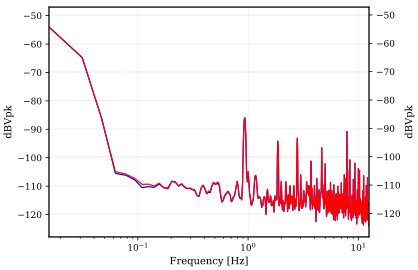

In [17]:
fig, ax = plt.subplots(1)
ax.semilogx(fA, dataA)
ax.set_ylabel(unitA)
ax.set_xlabel("Frequency [Hz]")
ax2 = ax.twinx()
ax2.semilogx(fB, dataB, 'r')

ax.set_ylabel(unitA)
ax2.set_ylabel(unitB)
plt.xlabel("Frequency [Hz]")
plt.tight_layout()

In [28]:
fB, dataB, unitB = download_data(gpib, 'B')

In [42]:
import struct
import sys
with open("spectrum.dat", 'wb') as myfile:
    for i in range(3600*9):
        time.sleep(10)
        try:
            ts = time.time()
            sys.stdout.write(f"\r{ts}")
            sys.stdout.flush()
            _, data, _ = download_data(gpib, 'B')
            floats = np.hstack(((ts,), data))
            myfile.write(struct.pack('d'*len(floats), *floats))
        except Exception as ex:
            print(ex)
        finally:
            myfile.flush()


1562508856.630124
1562509205.921777
1562509424.07844
1562510267.560269
1562510383.8794491
1562511024.4442801
1562511286.5867689
1562512553.612389
1562512684.669199
1562513514.830545
1562513733.307917
1562514228.5514839
1562515510.268899
1562516136.4972951
1562516486.032716
1562516646.2351239
1562516704.5062232
1562516937.533408
1562517054.029331
1562517607.472367
1562517927.883837
1562519398.777586
1562519923.077014
1562520971.755587
1562521685.500134
1562521758.3155441
1562522705.036704
1562523520.608757
1562523564.307935
1562523855.600075
1562524612.942399
1562524685.757281'utf-8' codec can't decode byte 0xc8 in position 1: invalid continuation byte
1562525835.1146188
1562527160.494426
1562527189.628386
1562527233.3118122
1562527320.704108'utf-8' codec can't decode byte 0xba in position 1: invalid start byte
1562527333.854445'utf-8' codec can't decode byte 0x90 in position 1: invalid start byte
1562528218.927277
1562528524.782432
1562529544.271981
1562529777.3208902
1562529850.142671

KeyboardInterrupt: 

In [60]:
b = bytes()
with open("spectrum.dat", 'rb') as myfile:
    d = myfile.read()
    while d != b'':
        b += d
        d = myfile.read()
        #f = struct.unpack('d'*803, d)

In [119]:
l = int(802*8)
N = len(b)//l
spectrums = np.zeros((N, 801), dtype=np.float64)
Ts = np.zeros((N,), dtype=np.float64)

for n ,i in enumerate(list(range(0, len(b), l))):
    d = struct.unpack('d'*802, b[i:(i+l)])
    Ts[n] = d[0]
    spectrums[n,:] = d[1:]

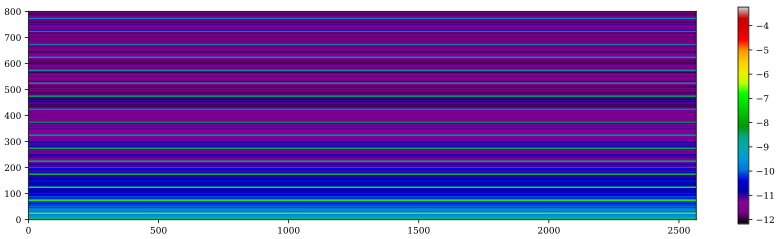

In [129]:
plt.figure(dpi=300, figsize=(15, 4))
plt.imshow(np.log10(spectrums).T, cmap='nipy_spectral')
plt.grid(False)
plt.colorbar()

In [1]:
df = fA[1]-fA[0]

NameError: name 'fA' is not defined

In [26]:
import numpy as np
D = np.load("/Users/ddb/ownCloud3/labc/frequency_lock_50Hz_intensity_servo_2.npz", allow_pickle=True)

In [39]:
f, Y, unit = D['data'][0]

In [45]:
df = f[1]-f[0]
df*np.sum(10**(Y/20))

0.5349358320236206

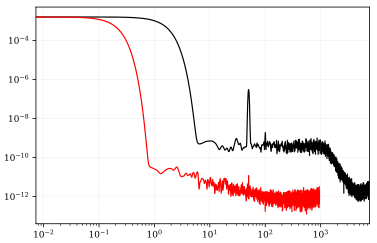

In [22]:
plt.figure()
db = pyrpl.curvedb.CurveDB()
f1, err_spec1 = db.get(79).data
plt.loglog(f1, err_spec1, c[0], zorder=-10)
f2, err_spec2 = db.get(78).data
plt.loglog(f2, err_spec2, c[1], zorder=10)